# "Cross-validation" des modèles

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Hyper-parametres
learning_rate = 0.04
num_epochs = 400
N = 200            
N_cv = 40
seed = 42
batch_size = N//4
#batch_size = N//2
N_test = 0
N_test = 2000      
N_scan = 9
bias = True


p0 = 0.02         
theta0 = 0
wt = np.pi/20      
theta_std = np.pi/6



## Creer des données synthetiques 

In [59]:
def get_data(
            N = N,
            p0 = p0,
            theta0 = theta0,
            wt = wt,
            theta_std = theta_std,
            seed=seed):
    np.random.seed(42)
    theta = np.random.randn(N)*theta_std
    a = (theta-theta0)/wt
    p = 1/(1+np.exp(-a))
    
    p = p0/2 + (1-p0) * p #add lapse rate
    y = np.random.rand(N) < p #generate data
    return theta, p, y

In [60]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type('torch.DoubleTensor')
criterion = torch.nn.BCELoss()

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, bias=True, logit0=-2): 
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(1, 1, bias=bias)    
        self.logit0 = torch.nn.Parameter(logit0*torch.ones(1))

    def forward(self, theta):
        out = self.logit0.sigmoid()/2 + (1-self.logit0.sigmoid())*self.linear(theta).sigmoid()
        return out
        

def fit_data(theta, y, 
                learning_rate =learning_rate,
                num_epochs = num_epochs,
                batch_size = batch_size,
                verbose=False):

    logistic_model = LogisticRegressionModel()

    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])

    loader = DataLoader(TensorDataset(Theta, labels), batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate/len(loader))
    
    for epoch in range(int(num_epochs)):
        losses = []
        for Theta_, labels_ in loader:
            optimizer.zero_grad()
            outputs = logistic_model(Theta_)
            loss = criterion(outputs, labels_)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        if verbose and (epoch % (num_epochs//32) == 0) : 
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")

    logistic_model.eval()
    return logistic_model, np.mean(losses)

In [17]:
torch.sigmoid(torch.tensor([-3.]))

tensor([0.0474])

In [18]:
%%timeit
theta, p, y = get_data()

59.8 µs ± 46.4 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [61]:
theta, p, y = get_data()
logistic_model, loss = fit_data(theta, y,verbose=True) 

Iteration: 0 - Loss: 0.70028
Iteration: 12 - Loss: 0.62015
Iteration: 24 - Loss: 0.56206
Iteration: 36 - Loss: 0.51705
Iteration: 48 - Loss: 0.48295
Iteration: 60 - Loss: 0.45664
Iteration: 72 - Loss: 0.43619
Iteration: 84 - Loss: 0.42004
Iteration: 96 - Loss: 0.40703
Iteration: 108 - Loss: 0.39646
Iteration: 120 - Loss: 0.38780
Iteration: 132 - Loss: 0.38049
Iteration: 144 - Loss: 0.37447
Iteration: 156 - Loss: 0.36932
Iteration: 168 - Loss: 0.36508
Iteration: 180 - Loss: 0.36129
Iteration: 192 - Loss: 0.35816
Iteration: 204 - Loss: 0.35545
Iteration: 216 - Loss: 0.35317
Iteration: 228 - Loss: 0.35111
Iteration: 240 - Loss: 0.34942
Iteration: 252 - Loss: 0.34794
Iteration: 264 - Loss: 0.34661
Iteration: 276 - Loss: 0.34547
Iteration: 288 - Loss: 0.34451
Iteration: 300 - Loss: 0.34373
Iteration: 312 - Loss: 0.34290
Iteration: 324 - Loss: 0.34241
Iteration: 336 - Loss: 0.34168
Iteration: 348 - Loss: 0.34118
Iteration: 360 - Loss: 0.34079
Iteration: 372 - Loss: 0.34038
Iteration: 384 - L

In [62]:
with torch.no_grad():
    if bias: print('bias', logistic_model.linear.bias.item())
    print('slope', logistic_model.linear.weight.item())    
    print('p0', torch.sigmoid(logistic_model.logit0).item())


bias -0.03673703736677096
slope 6.205338493504975
p0 0.002738091559826205


loss= 0.339647100591


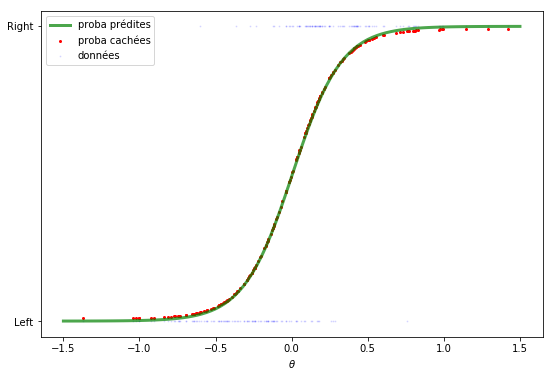

In [63]:
print('loss=', loss)
plt.figure(figsize = (9,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();


In [22]:
%%timeit
logistic_model, loss = fit_data(theta, y, verbose=False)

2.9 s ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## validation

loss= tensor(0.3396, grad_fn=<BinaryCrossEntropyBackward>)


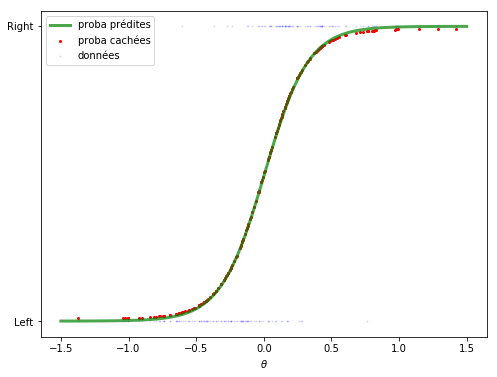

In [64]:
theta, p, y = get_data() # nouvelles données 

labels = torch.Tensor(y[:, None])
Theta = torch.Tensor(theta[:, None])
outputs = logistic_model(Theta)
loss = criterion(outputs, labels)
print('loss=', loss)
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();

## influence du nombre de trials

In [24]:
Ns = np.logspace(1, 3, N_scan, base=10)

Ns_, losses, loss_Ps, loss_P0s = [], [], [], []

for N_ in Ns:
    for i_CV in range(N_cv):
        theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        P = torch.Tensor(p[:, None])
        
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels).item()
    
        loss_P = criterion(outputs, P).item() 
        loss_P0 = criterion(P, P).item()
        
        if i_CV==0: print(f"N: {int(N_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        loss_P0s.append(loss_P0)
        Ns_.append(N_)
        loss_Ps.append(loss_P)
        losses.append(loss)
    

N: 10, Loss: 0.43061, loss_P: 0.43419, loss_P0: 0.36047
N: 17, Loss: 0.40887, loss_P: 0.41163, loss_P0: 0.36047
N: 31, Loss: 0.37468, loss_P: 0.37181, loss_P0: 0.36047
N: 56, Loss: 0.36518, loss_P: 0.36143, loss_P0: 0.36047
N: 100, Loss: 0.36832, loss_P: 0.36481, loss_P0: 0.36047
N: 177, Loss: 0.36530, loss_P: 0.36307, loss_P0: 0.36047
N: 316, Loss: 0.36481, loss_P: 0.36227, loss_P0: 0.36047
N: 562, Loss: 0.36435, loss_P: 0.36067, loss_P0: 0.36047
N: 1000, Loss: 0.36815, loss_P: 0.36320, loss_P0: 0.36047


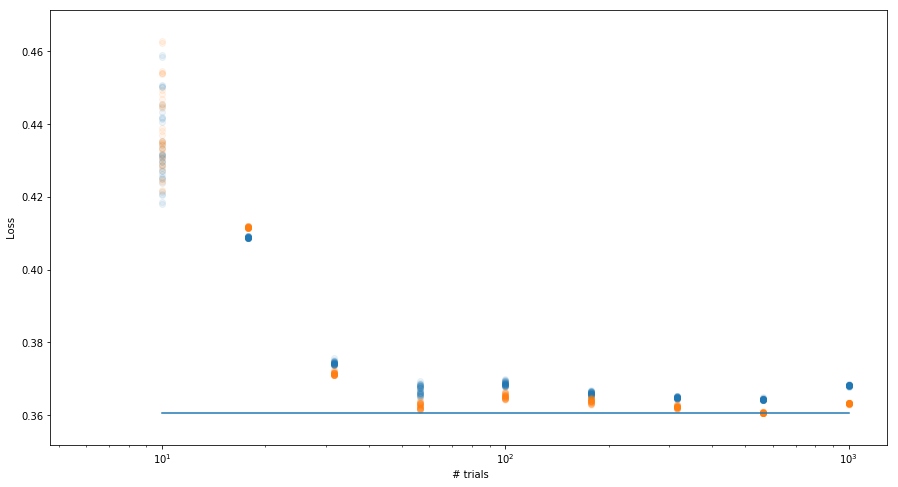

In [25]:
#plot

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(Ns_, losses, alpha=3/N_cv, label='loss')
ax.scatter(Ns_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(Ns_, loss_P0s, label='loss_P0')

ax.set_xlabel(' # trials')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')

## influence du nombre du learning rate


In [26]:
learning_rates = learning_rate * np.logspace(-1, 1, N_scan, base=10)
learning_rates_, losses, loss_Ps, loss_P0s = [], [], [], []
for learning_rate_ in learning_rates:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, learning_rate=learning_rate_, verbose=False)

        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"learning_rate: {learning_rate_:.5f}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        learning_rates_.append(learning_rate_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

learning_rate: 0.00400, Loss: 0.52832, loss_P: 0.52725, loss_P0: 0.36047
learning_rate: 0.00711, Loss: 0.41694, loss_P: 0.41492, loss_P0: 0.36047
learning_rate: 0.01265, Loss: 0.38692, loss_P: 0.38436, loss_P0: 0.36047
learning_rate: 0.02249, Loss: 0.37267, loss_P: 0.36968, loss_P0: 0.36047
learning_rate: 0.04000, Loss: 0.36537, loss_P: 0.36141, loss_P0: 0.36047
learning_rate: 0.07113, Loss: 0.36522, loss_P: 0.36164, loss_P0: 0.36047
learning_rate: 0.12649, Loss: 0.37047, loss_P: 0.36682, loss_P0: 0.36047
learning_rate: 0.22494, Loss: 0.37246, loss_P: 0.36889, loss_P0: 0.36047
learning_rate: 0.40000, Loss: 0.37286, loss_P: 0.36917, loss_P0: 0.36047


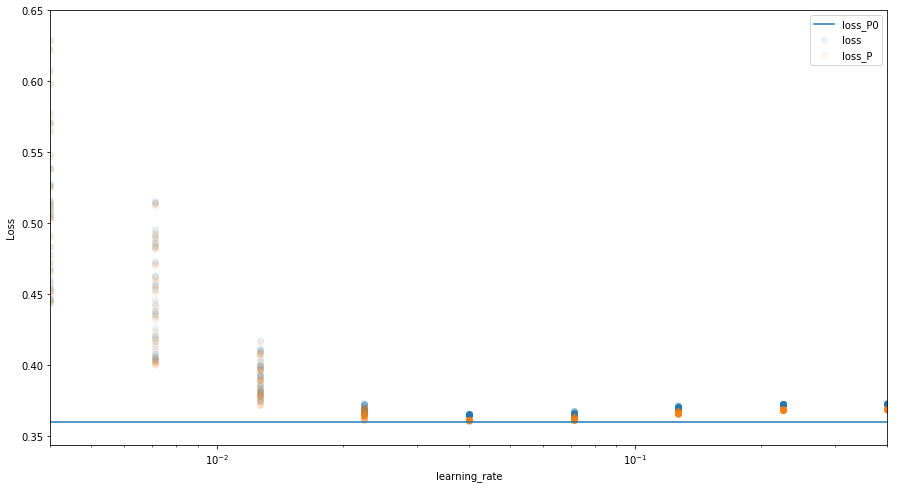

In [27]:
#influence du learning rate sur loss

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(learning_rates_, losses, alpha=3/N_cv, label='loss')
ax.scatter(learning_rates_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(learning_rates_, loss_P0s, label='loss_P0')
ax.set_xlim(np.min(learning_rates_), np.max(learning_rates_))

ax.set_xlabel('learning_rate')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## influence du nombre d'epochs

In [28]:
num_epochss = num_epochs * np.logspace(-1, 1, N_scan, base=10)
num_epochss_, losses, loss_Ps, loss_P0s = [], [], [], []
for num_epochs_ in num_epochss:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, num_epochs=int(num_epochs_), verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"num_epochs: {int(num_epochs_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        num_epochss_.append(num_epochs_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

num_epochs: 40, Loss: 0.54869, loss_P: 0.54757, loss_P0: 0.36047
num_epochs: 71, Loss: 0.42717, loss_P: 0.42526, loss_P0: 0.36047
num_epochs: 126, Loss: 0.41017, loss_P: 0.40807, loss_P0: 0.36047
num_epochs: 224, Loss: 0.36564, loss_P: 0.36211, loss_P0: 0.36047
num_epochs: 400, Loss: 0.36562, loss_P: 0.36161, loss_P0: 0.36047
num_epochs: 711, Loss: 0.36560, loss_P: 0.36198, loss_P0: 0.36047
num_epochs: 1264, Loss: 0.37187, loss_P: 0.36820, loss_P0: 0.36047
num_epochs: 2249, Loss: 0.37280, loss_P: 0.36918, loss_P0: 0.36047
num_epochs: 4000, Loss: 0.37282, loss_P: 0.36920, loss_P0: 0.36047


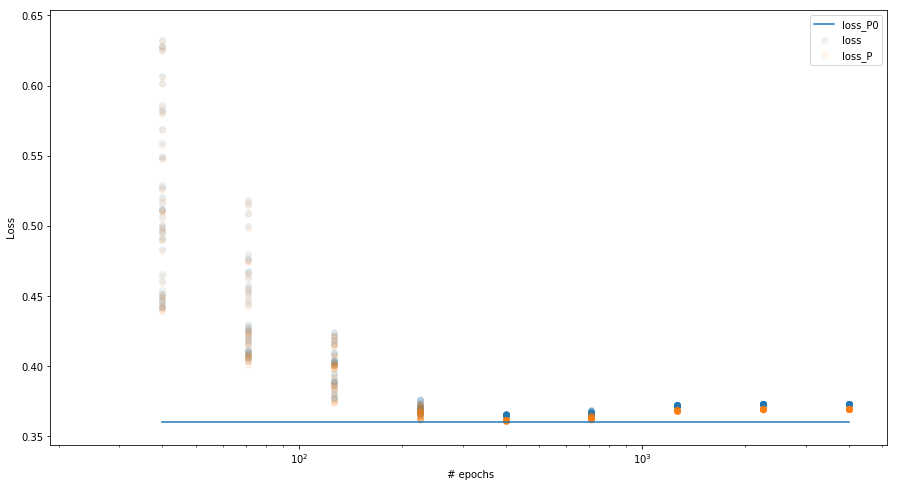

In [29]:
# influence du nbr d'epochs sur loss 
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(num_epochss_, losses, alpha=3/N_cv, label='loss')
ax.scatter(num_epochss_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(num_epochss_, loss_P0s, label='loss_P0')

ax.set_xlabel(' # epochs')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## influence de la taille du minibatch

In [30]:
batch_sizes = N * np.logspace(-3, 0, N_scan, base=2)
batch_sizes_, losses, loss_Ps, loss_P0s = [], [], [], []
for batch_size_ in batch_sizes:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, batch_size=int(batch_size_), verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"batch_size: {int(batch_size_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        batch_sizes_.append(batch_size_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

batch_size: 25, Loss: 0.36561, loss_P: 0.36169, loss_P0: 0.36047
batch_size: 32, Loss: 0.36564, loss_P: 0.36154, loss_P0: 0.36047
batch_size: 42, Loss: 0.36573, loss_P: 0.36170, loss_P0: 0.36047
batch_size: 54, Loss: 0.36527, loss_P: 0.36139, loss_P0: 0.36047
batch_size: 70, Loss: 0.36549, loss_P: 0.36151, loss_P0: 0.36047
batch_size: 91, Loss: 0.36511, loss_P: 0.36136, loss_P0: 0.36047
batch_size: 118, Loss: 0.36494, loss_P: 0.36112, loss_P0: 0.36047
batch_size: 154, Loss: 0.36580, loss_P: 0.36165, loss_P0: 0.36047
batch_size: 200, Loss: 0.36566, loss_P: 0.36165, loss_P0: 0.36047


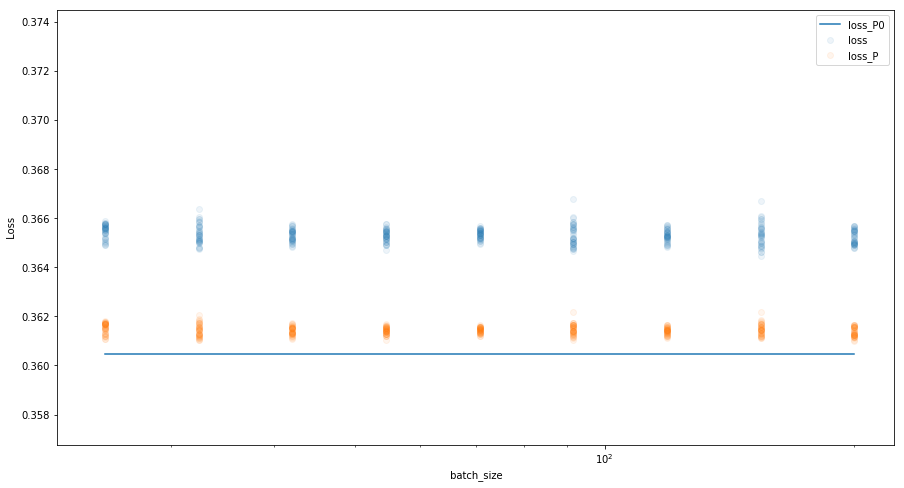

In [31]:
# influence de la taille du minibatch sur loss 

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(batch_sizes_, losses, alpha=3/N_cv, label='loss')
ax.scatter(batch_sizes_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(batch_sizes_, loss_P0s, label='loss_P0')

ax.set_xlabel(' batch_size')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## Comparaison données générées/données prédites

## Torch

In [11]:
theta0s = np.random.randn(50)
p0s = np.linspace(0, 1, 50)
wts = np.logspace(-1, 1, 50, base=10)

#preds = {'torch':{'theta0_preds':[], 'wt_preds':[], 'p0_preds':[]}, 
#         'sklearn':{'theta0_preds':[], 'wt_preds':[], 'p0_preds':[]}}

p0_preds, theta0_preds, wt_preds = [],[],[]

for p0_ in p0s: 
    
    seed_ = range(seed)
    theta, p, y = get_data(p0=p0_,seed=seed_)  #seed =seed_
    logistic_model, loss = fit_data(theta, y, verbose=False)
    p0_pred =  torch.sigmoid(logistic_model.logit0).item()            
    p0_preds.append(p0_pred)
    
for theta0_ in theta0s:
    seed_ = range(seed)
    theta, p, y = get_data(theta0=theta0_,seed=seed_) 
    logistic_model, loss = fit_data(theta, y, verbose=False)
    theta0_pred = logistic_model.linear.bias.item()
    theta0_preds.append(theta0_pred)
                   
for wt_ in wts:
    seed_ = range(seed)
    theta, p, y = get_data(wt=wt_, seed=seed_)
    logistic_model, loss = fit_data(theta, y, verbose=False)
    wt_pred = logistic_model.linear.weight.item() 
    wt_preds.append(wt_pred)
    
        
      

## Sklearn

In [51]:
def fit_lr(
            N = N,
            p0 = p0,
            theta0 = theta0,
            wt = wt,
            theta_std = theta_std,
            seed = seed):
    theta = np.random.randn(N)*theta_std
    a = (theta-theta0)*wt
    p = p0/2 + ((1-p0)/(1+np.exp(-a)))
    y = np.random.rand(N) < p 

    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(solver='liblinear', C = 3, max_iter=1000, penalty='l2', class_weight = {1 : 1 , 0 : 1})
    model.fit(theta[:, None], y)
    return theta, p, y, model



In [79]:
 theta0_pre, wt_pre  = [],[]
    
for theta0_ in theta0s:
    seed_ = range(seed)
    theta, p, y, model = fit_lr(theta0=theta0_, seed = seed_)
    theta0_pre.append(model.intercept_[0])

for wt_ in wts:
    seed_ = range(seed)
    theta, p, y, model = fit_lr(wt=wt_, seed = seed_)
    wt_pre.append(model.coef_[0][0])


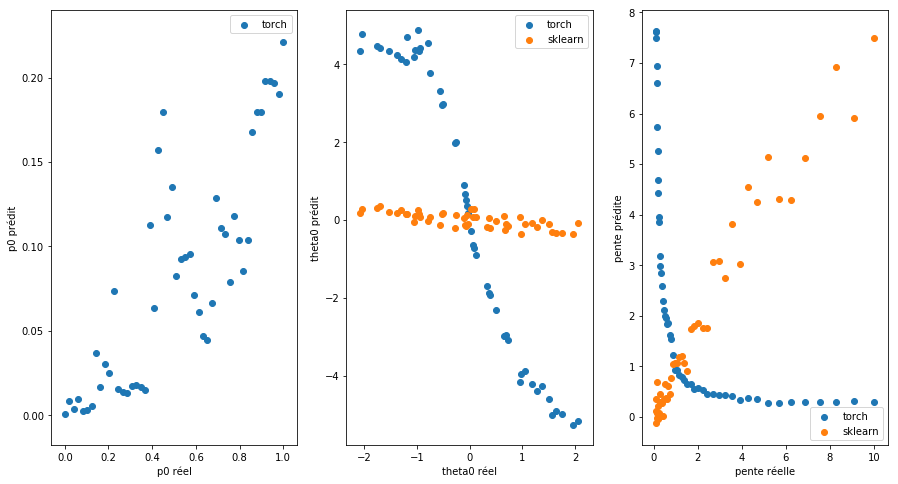

In [78]:
# TODO : show three panels

fig, axs= plt.subplots(1, 3, figsize = (15, 8)) 

axs[0].scatter(p0s, p0_preds, label='torch')
#axs[0].scatter(0, 0, label='sklearn')
axs[0].set(xlabel='p0 réel',ylabel='p0 prédit')
axs[0].legend()

axs[1].scatter(theta0s, theta0_preds,label='torch')
axs[1].scatter(theta0s, theta0_pre,label='sklearn')
axs[1].set(xlabel='theta0 réel',ylabel='theta0 prédit')
axs[1].legend()

axs[2].scatter(wts, wt_preds,label='torch')
axs[2].scatter(wts, wt_pre,label='sklearn')
axs[2].set(xlabel='pente réelle',ylabel='pente prédite')
axs[2].legend()